# Using Natural Language Processing to Generate New Recipes

## A. Importation des bibliothèques

In [32]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
import json
import tqdm

from model_demo import demo
from transformers import AutoTokenizer, AutoModelForCausalLM

## B. Chargement des bibliothèques

In [2]:
#!git clone https://github.com/huggingface/transformers; 
#!cd transformers; pip install .

## C. Tâche 1: Démonstration

In [3]:
# Démo 1

demo('Ingredients:\n \
     1 1/4 tablespoons paprika \n \
     1 tablespoon kosher salt \n \
     1 teaspoon garlic powder \n \
     1/2 teaspoon ground black pepper \n \
     1/2 teaspoon onion powder \n \
     1/2 teaspoon ground cayenne pepper \n \
     1/2 teaspoon dried oregano \n \
     1/2 teaspoon dried thyme \n \
     2 tablespoons olive oil \n \
     1 (3 pound) sirloin tip roast \n \n Instructions')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


------------------
Generated Output
------------------
Ingredients:
      1 1/4 tablespoons paprika 
      1 tablespoon kosher salt 
      1 teaspoon garlic powder 
      1/2 teaspoon ground black pepper 
      1/2 teaspoon onion powder 
      1/2 teaspoon ground cayenne pepper 
      1/2 teaspoon dried oregano 
      1/2 teaspoon dried thyme 
      2 tablespoons olive oil 
      1 (3 pound) sirloin tip roast 
 
 Instructions: 
 Preheat oven to 350 degrees F (175 degrees C). Line a baking sheet with aluminum foil. Whisk paprika, kosher salt, garlic powder, black pepper, onion powder, cayenne pepper, oregano, and thyme together in a bowl. Rub olive oil all over the meat, reserving 2 tablespoons for the sauce. Arrange the roast on the prepared baking sheet. Brush any remaining oil from the foil over the meat. Roast the roast in the preheated oven until the roast is tender, 45 to 55 minutes. An instant-read thermometer inserted into the center should read at least 145 degrees F (63 degree

In [4]:
# Démo 2

demo('Ingredients:\n \
     1 1/4 tablespoons paprika \n \
     1 tablespoon kosher salt \n \
     1 teaspoon garlic powder \n \
     1/2 teaspoon ground black pepper \n \
     1/2 teaspoon onion powder \n \
     1/2 teaspoon ground cayenne pepper \n \
     1/2 teaspoon dried oregano \n \
     1/2 teaspoon dried thyme \n \
     2 tablespoons olive oil \n \
     1 (3 pound) sirloin tip roast \n \n Instructions')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


------------------
Generated Output
------------------
Ingredients:
      1 1/4 tablespoons paprika 
      1 tablespoon kosher salt 
      1 teaspoon garlic powder 
      1/2 teaspoon ground black pepper 
      1/2 teaspoon onion powder 
      1/2 teaspoon ground cayenne pepper 
      1/2 teaspoon dried oregano 
      1/2 teaspoon dried thyme 
      2 tablespoons olive oil 
      1 (3 pound) sirloin tip roast 
 
 Instructions: 
 Mix paprika, kosher salt, garlic powder, black pepper, onion powder, cayenne pepper, oregano, and thyme together in a bowl. Place roast in the bowl; cover and marinate in the refrigerator at least 1 hour. Remove meat from marinade using a slotted spoon. Discard marinade. Remove roast from marinade; discard any remaining marinade. Heat olive oil in a skillet over medium heat. Cook and stir beef roast in hot oil until browned and crumbly, about 10 minutes. An instant-read thermometer inserted into the center should read at least 145 degrees F (63 degrees C).  


## D. Tache 2 - Analyse exploratoire des données et prétraitement 

In [5]:
# Chargement des données de la source ar dans un dictionnaire de données

data = json.load(open('Dataset/recipes_raw_nosource_ar.json', 'r'))

In [6]:
# Affichage de la valeur de la clé 0

keys = list(data.keys())
data[keys[0]]

{'title': 'Slow Cooker Chicken and Dumplings',
 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT',
  '2 tablespoons butter ADVERTISEMENT',
  '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT',
  '1 onion, finely diced ADVERTISEMENT',
  '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT',
  'ADVERTISEMENT'],
 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n',
 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'}

In [7]:
# Chargement du dictionnaire dans une trame de données 

df = pd.DataFrame()

recipe_sources = ["ar", 'epi', 'fn']

sources, titles, ingredients, instructions = [], [], [], []

for recipe_source in recipe_sources:
    data = json.load(open(f'Dataset/recipes_raw_nosource_{recipe_source}.json', 'r'))
    
    for _, recipe in data.items():
        if ('title' in recipe) and ('ingredients' in recipe) and ('instructions' in recipe):                    
            sources.append(recipe_source)
            titles.append(recipe['title'])
            ingredients.append([ingredient.replace('ADVERTISEMENT', '') for ingredient in recipe['ingredients']])       
            instructions.append(str(recipe['instructions']).replace('ADVERTISEMENT', '').replace('\n', ' '))
        
df['source'] = sources
df['title'] = titles  
df['ingredients'] = ingredients  
df['instructions'] = instructions  

In [8]:
# Affichage des premières données de la trame

df.head()

,source,title,ingredients,instructions
0,ar,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves , ...","Place the chicken, butter, soup, and onion in ..."
1,ar,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,ar,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar , 1/2 cup ketchup ...",Preheat oven to 350 degrees F (175 degrees C)....
3,ar,Best Chocolate Chip Cookies,"[1 cup butter, softened , 1 cup white sugar , ...",Preheat oven to 350 degrees F (175 degrees C)....
4,ar,Homemade Mac and Cheese Casserole,"[8 ounces whole wheat rotini pasta , 3 cups fr...",Preheat oven to 350 degrees F. Line a 2-quart ...


In [9]:
# Ajout de deux caratéristiques: le nombre d'ingrédients et la longueur des instructions des recettes de cuisine

df['ingredient_count'] = df['ingredients'].str.len().fillna(0).astype(int)
df['instruction_length'] = df['instructions'].str.split().str.len().fillna(0).astype(int)

In [10]:
# Affichage des premières données de la trame de données avec les nouvelles caratéristiques

df.head()

,source,title,ingredients,instructions,ingredient_count,instruction_length
0,ar,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves , ...","Place the chicken, butter, soup, and onion in ...",6,53
1,ar,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ...",5,44
2,ar,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar , 1/2 cup ketchup ...",Preheat oven to 350 degrees F (175 degrees C)....,11,67
3,ar,Best Chocolate Chip Cookies,"[1 cup butter, softened , 1 cup white sugar , ...",Preheat oven to 350 degrees F (175 degrees C)....,12,74
4,ar,Homemade Mac and Cheese Casserole,"[8 ounces whole wheat rotini pasta , 3 cups fr...",Preheat oven to 350 degrees F. Line a 2-quart ...,14,175


<AxesSubplot:xlabel='source', ylabel='ingredient_count'>

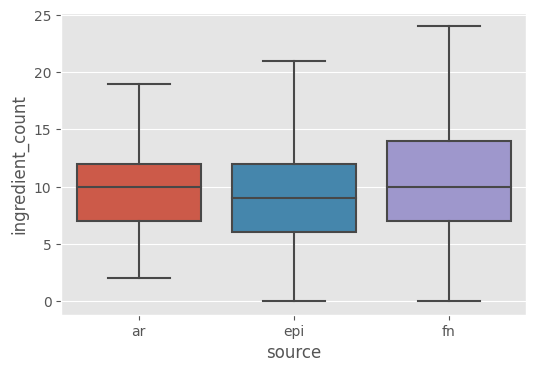

In [11]:
# Affichage du boxplot du nombre des ingrédients des recettes en fonction des sources des recettes

sns.boxplot(data=df, x='source', y='ingredient_count', showfliers=False )

<AxesSubplot:xlabel='source', ylabel='instruction_length'>

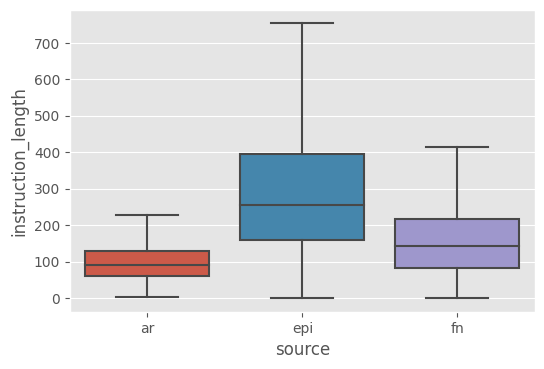

In [12]:
# Affichage du boxplot de la longueur des recettes en fonction des sources des recettes

sns.boxplot(data=df, x='source', y='instruction_length', showfliers=False )

## E. Tache 3 - Préparation des données

In [13]:
# Sont conservés uniquement les recettes qui contiennent au moins 3 ingredients 
# et dont la longueur des instructions est supérieure ou égale à 10

print(df.shape)
df = df[(df.ingredient_count>=3) & (df.instruction_length>=10)]
print(df.shape)

(124647, 6)
(121780, 6)


In [14]:
# Création d'une nouvelle caratéristique qui combine les ingredients et les instructions associées

special_token = ' <|endoftext|> '

df['combined'] = ' \n Ingredients: \n ' + df.ingredients.str.join(' \n ') + ' \n Instruction: \n ' + \
                df.instructions + special_token

In [15]:
# Affichage combiné des ingrédients et des instructions de cette recette

print(df.iloc[100].combined)

 
 Ingredients: 
 1/2 cup butter, melted  
 2 eggs, beaten  
 1 (8.5 ounce) package dry corn bread mix  
 1 (15 ounce) can whole kernel corn, drained  
 1 (14.75 ounce) can creamed corn  
 1 cup sour cream  
  
 Instruction: 
 Preheat oven to 350 degrees F (175 degrees C), and lightly grease a 9x9 inch baking dish. In a medium bowl, combine butter, eggs, corn bread mix, whole and creamed corn and sour cream. Spoon mixture into prepared dish. Bake for 45 minutes in the preheated oven, or until the top is golden brown.  <|endoftext|> 


In [16]:
# Séparation des données en données d'entrainement (80%) et données de validation (20%)

dataset_train = df[:int(len(df)*80/100)].combined.values
dataset_val = df[int(len(df)*80/100):].combined.values

with open('Dataset/dataset_train.txt', 'w') as f:
    f.write('\n'.join(dataset_train))
    
with open('Dataset/dataset_val.txt', 'w') as f:
    f.write('\n'.join(dataset_val))

## F. Tache 4 - Formulation et théorie du modèle pré-entraîné GPT-2 

In [17]:
tokenizer = AutoTokenizer.from_pretrained('distilgpt2')
model = AutoModelForCausalLM.from_pretrained('distilgpt2')

In [18]:
prompt_text = 'Yesterday, I walked to the shop, and'

encoded_prompt = tokenizer.encode(
    prompt_text,
    add_special_tokens=False,
    return_tensors='pt'
)

encoded_prompt

tensor([[28065,    11,   314,  6807,   284,   262,  6128,    11,   290]])

In [19]:
output_sequences = model.generate(
    input_ids=encoded_prompt,
    max_length=700,
    temperature=0.9,
    top_k=20,
    top_p=0.9,
    repetition_penalty=1,
    do_sample=True,
    num_return_sequences=2
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [20]:
#output_sequences[0]
tokenizer.decode(output_sequences[0])

"Yesterday, I walked to the shop, and my friend asked me what my favorite food to eat. We both had to eat a bunch of beans, and I was just a bit confused. I thought it was pretty cool. I was surprised that this was the type of food I'd ever had, and was happy to share it with you.\n\n\nI was actually surprised to learn about this stuff because I love food!\nI also found a lot of great stuff that I love, and I am always surprised to find a few that are so good to eat.\nIt was pretty easy to make a few of these sandwiches with a few ingredients, but it didn't last long. This was a good thing! It was so good, and it made me want to go and make some! It's a really easy thing.\nI think I've always been a big fan of this stuff, and I'm just a little disappointed that it never came out. I can't imagine what would have happened if I had never had a sandwich with my own. I would've had it, but it was too small, too large, too small and too big, too small, too big, too small and too big. The san

## G. Tache 5 - - Entrainement du modèle

In [21]:
# !bash run_experiments.sh

In [29]:
model = AutoModelForCausalLM.from_pretrained('TrainedModels/Model_10_epochs/')

In [31]:
configuration = model.config
configuration

GPT2Config {
  "_name_or_path": "TrainedModels/Model_10_epochs/",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.3.2",
  "use_cache": true,
  "vocab_size": 50257
}

## H. Tache 6 - Réglage des performance du modèle

In [23]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [24]:
tokenizer = AutoTokenizer.from_pretrained('TrainedModels/Model_10_epochs/')
model = AutoModelForCausalLM.from_pretrained('TrainedModels/Model_10_epochs/')

In [25]:
with open('Dataset/dataset_val.txt', 'r') as f:
    data=f.read()

In [26]:
special_token = ' <|endoftext|> '

In [27]:
data = data.split(special_token)

In [28]:
for i in range(10):
        print(data[i])

 
 Ingredients: 
 2 (3.75-ounce 2-layer) tins brisling sardines in olive oil 
 2 tablespoons finely chopped parsley leaves, divided 
 1 tablespoon sherry vinegar 
 1/4 teaspoon lemon zest, reserve the lemon and cut into 4 wedges 
 Freshly ground black pepper 
 4 (1/2-inch) thick slices crusty bread, such as sourdough, country loaf or rye 
 1 ripe Hass avocado 
 Coarse sea salt 
 Instruction: 
 Watch how to make this recipe. Drain the oil from 1 tin of sardines into a small bowl and set aside. Drain the oil from the other tin into another small bowl and whisk in 1 tablespoon of parsley, vinegar, lemon zest, and black pepper, to taste. Add the sardines, stir to combine and set aside for up to 1 hour. After 45 minutes, put a rack 3-inches from the broiler and heat the oven to the broiler setting on high. Brush each slice of bread on 1 side with the reserved oil. Put the bread, oil side up, onto a cooling rack set inside a half sheet pan and broil 2 to 3 minutes or until golden brown and c